In [1]:
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from pdfminer.converter import PDFPageAggregator
from pdfminer.converter import PDFPageAggregator
from io import StringIO
import os
import codecs
import re
import tabula


In [2]:
# From this cell and below I follow the tutorial at http://www.degeneratestate.org/posts/2016/Jun/15/extracting-tabular-data-from-pdfs/

# Test on Cook Island file page 8
file = 'Approved Plans/Cook Islands/MDR00005cdrp_cook_islands.pdf'

In [4]:
def extract_layout_by_page(pdf_path):
    """
    Extracts LTPage objects from a pdf file.
    
    slightly modified from
    https://euske.github.io/pdfminer/programming.html
    """
    laparams = LAParams()

    fp = open(pdf_path, 'rb')
    parser = PDFParser(fp)
    document = PDFDocument(parser)

    if not document.is_extractable:
        raise PDFTextExtractionNotAllowed

    rsrcmgr = PDFResourceManager()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    layouts = []
    for page in PDFPage.create_pages(document):
        # only pages with landscape orientation
        if page.cropbox[2] < 800:
            continue

        interpreter.process_page(page)
        layouts.append(device.get_result())

    return layouts


page_layouts = extract_layout_by_page(file)

In [15]:
len(page_layouts)

7

In [6]:
objects_on_page = set(type(o) for o in page_layouts[3])
objects_on_page

{pdfminer.layout.LTCurve,
 pdfminer.layout.LTFigure,
 pdfminer.layout.LTRect,
 pdfminer.layout.LTTextBoxHorizontal}

In [7]:
import pdfminer

TEXT_ELEMENTS = [
    pdfminer.layout.LTTextBox,
    pdfminer.layout.LTTextBoxHorizontal,
    pdfminer.layout.LTTextLine,
    pdfminer.layout.LTTextLineHorizontal
]

def flatten(lst):
    """Flattens a list of lists"""
    return [subelem for elem in lst for subelem in elem]


def extract_characters(element):
    """
    Recursively extracts individual characters from 
    text elements. 
    """
    if isinstance(element, pdfminer.layout.LTChar):
        return [element]

    if any(isinstance(element, i) for i in TEXT_ELEMENTS):
        return flatten([extract_characters(e) for e in element])

    if isinstance(element, list):
        return flatten([extract_characters(l) for l in element])

    return []

In [8]:
current_page = page_layouts[1]

texts = []
rects = []

# seperate text and rectangle elements
for e in current_page:
    if isinstance(e, pdfminer.layout.LTTextBoxHorizontal):
        texts.append(e)
    elif isinstance(e, pdfminer.layout.LTRect) or isinstance(e, pdfminer.layout.LTCurve):
        rects.append(e)

# sort them into 
characters = extract_characters(texts)

In [9]:
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

def draw_rect_bbox( x, ax, color):
    """
    Draws an unfilled rectable onto ax.
    """
    x0,y0,x1,y1 = x
    ax.add_patch(patches.Rectangle((x0,y0),x1-x0, y1-y0, fill=False, color=color))

   
    
def draw_rect(rect, ax, color="black"):
    draw_rect_bbox(rect.bbox, ax, color)

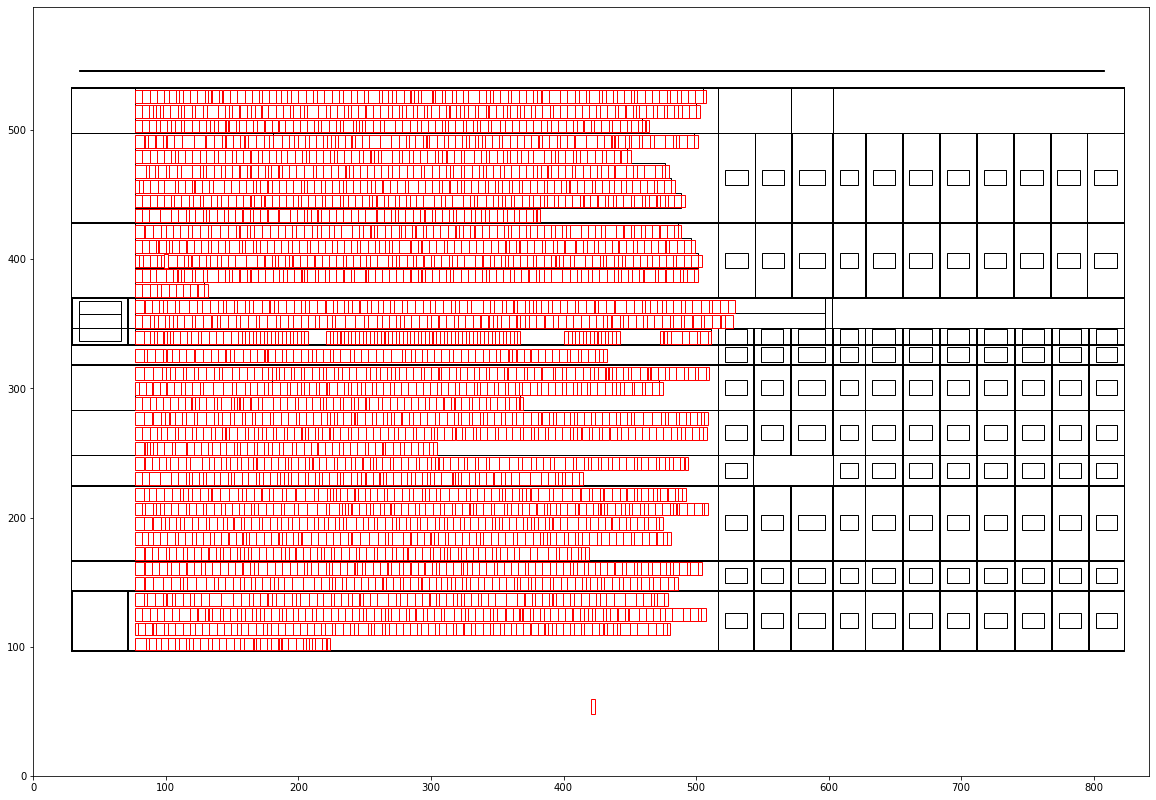

In [12]:
# visualise characters and rectangels on page

xmin, ymin, xmax, ymax = current_page.bbox
size = 20

fig, ax = plt.subplots(figsize = (size, size * (ymax/xmax)))

for rect in rects:
    draw_rect(rect , ax)

# Select all the characters that fall within a certain range on the page.
# This part might make it hard to generalize because this will not work for every page.
# We could also try to find a solution by filtering based on the rectangles (widths, areas etc.)
relevant_characters = []
for c in characters:
    if c.x0 > 75 and c.x1 < 530:
        relevant_characters.append(c)
        draw_rect(c, ax, "red")
    

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

In [13]:
# transform all characters to sentences
rows = sorted(list(set(c.bbox[1] for c in relevant_characters)), reverse=True)
text = ""

for row in rows:
    sorted_row = sorted([c for c in relevant_characters if c.bbox[1] == row], key=lambda c: c.bbox[0])
    text += "".join(c.get_text() for c in sorted_row)
    

# Find all activity titles    
indeces = re.finditer(r".\s([A-Z])(\w+\s?){1,10}:", text)

for i,match in enumerate(indeces):
    if i == 0:
        previous_page = text[:match.start(0)]
        start = match.start(0)
        print(i)
        print(previous_page)
    else:
        activity = text[start:match.start(0)]
        start = match.start(0)
        print(i)
        print(activity)
    # does not print last activity


0
general health behaviours and address mistrust, misinformation and rumours with actionable and verified information- schools, market vendors, etc. This training is to be conducted online via the use of video training packages that will be made available to Branches and volunteers.
1
  Risk communication: Carry out risk communication activities based on community information needs, concerns and perceptions, share timely and trustworthy information, address misinformation and build knowledge, acceptance and intention about signs and symptoms, transmission modes, preventive actions (hand washing, social distancing) and care-seeking behaviours by people experiencing respiratory symptoms. Participate in and contribute to risk communication and community engagement coordination structures
2
. Addressing Social cohesion: Promote local dialogue through the use of mass media about social cohesion with focus on addressing stigma and xenophobia and promote acceptance and trust.Set up a communit

In [11]:
# The rest of the tutorial works best if filtering the desired bounding boxes out of the page seems
# to work properly. For the pages I tested on this did not really work out but it might be something to 
# experiment with.